# Interpreting your Machine Learning Model : Why and How

[ _A tutorial made during the_ __[MLcourse.ai course](https://mlcourse.ai/)__ - 04/2019 - v1]

`Christophe Rigon > datacog@free.fr`


---
### __IMPORTANT NOTE__: 

I have a serious problem installing et running properlly here one of the main librariy of this tutorial (SKATER). I don't understand why... i've tried hard but couldn't fix it.

So I invite you to **look at it directly on my Github at** :

__https://github.com/cog-data/ML_Interpretability_tutorial/blob/master/Machine_Learning_Interpretability_tutorial.ipynb__

... and to come-back here after if you wish to upvote it.

Sorry for the inconvenience.


***

>_"models are opinions embedded in mathematics" - Cathy O'Neil (mathematician, data scientist and author of the famous "Weapons of Math Destruction")_

>_"Science without conscience is but the ruin of the Soul" - Rabelais (who first quoted the word "automaton" in french during the 16th century)_



<img src="https://raw.githubusercontent.com/cog-data/ML_Interpretability_tutorial/master/img/mli_fun.jpg" title="MLI Funny" height="228" width="405"/>

Machine Learning Interpretability of is a hot and crucial subject : machine learning algorithms are everywhere, becoming more and more ubiquitous, complex and efficient, and sometimes treated like __black-boxes__. They have already, and will have in the future, more and more impact on our society and our everyday's life. As (future) Data Scientist / Machine Learning Engineers, even if we clearly don't need interpretability all the time, I think we have a social and professional ethical duty trying to design models as **fair, accountable and transparent** as possible. Meaning : unbiasedness/non-discriminative, giving reliable results and being able to be queried to validate predictive decisions.The recent European GDRP (General Data Protection Regulation) resolution testifies to a citizen "right to explanation" of algorithmic decisions that "significantly" affect any individual. Further more, interpreting our machine learning processes could give us valuable insights for :

- debugging
- informing feature engineering
- model comparisons
- driving future data collection
- informing human decision-making
- and generally for better communication and trust building.

The intend of this tutorial is twofold :
- to give a basic introduction to the subject, looking at different strategies for tackling the potential "black-box" problem in a **model-agnostic** fashion. 
- to have a practical grasp on some of the main frameworks actually available for machine learning interpretability like __ELI5, LIME, SKATER, or SHAP__ (and also PDPbox and FairML). 

After loading and providing a [description of the data](#descrip_data), a [quick EDA](#eda), and [training/evaluating our model](#model), we will be exploring more in depth differents interpretation techniques like : 

1. [Features Importance (without and with permutation)](#features_importance)
2. [Partial Dependence Plots (PD plot)](#pd_plots) &  [Individual Conditional Expectation (ICE) plots](#ice_plots)
3. [Model Prediction Explanations with Local Interpretation (LIME)](#lime)
4. [SKATER model interpretation](#skater)
5. [Building Interpretable Models with Surrogate Tree-based Models (SKATER)](#skater_tree)
6. [Model Prediction Explanation with SHAP values](#shap)
7. [Dependence and Interaction Plots (SHAP)](#shap_plots)
8. [Bonus : auditing our "black-box predictive model" with FairML](#fairml)
9. [Further readings and conclusion](#further_readings)

We will work :
- on a real-world dataset about Red Wine Quality (after all ethics can, and should also be convivial ;)) 
- with an XGBoost model, which is a complex optimized distributed gradient boosting library providing a parallel tree boosting algorithm 
- and the learning task will be a classical supervised classification with binarized classes.



# Load dependencies

In [1]:
### Elementary my Dear Watson...
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 

### Some Scikit-learn utils
from sklearn.model_selection import train_test_split

### Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

### Models
from xgboost import XGBClassifier, plot_importance

########################################################
### For an easier workflow, Interpretability libraries
### will be installed/loaded on the fly of the tutorial
########################################################

### Some cosmetics add-ons
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline


# Load the Red Wine Quality Dataset

The Red Wine Quality dataset can be downloaded __[on this Kaggle page](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)__ or via the __[UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/wine+quality)__.

"This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference __[Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016)__. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.)."

In [2]:
# loading the csv dataset in a dataframe
df_raw = pd.read_csv('../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')
df_raw.shape

(1599, 12)

> I have chosen a small and clean dataset (1599 rows x 11+1 variables) for quick and easy (pre)processing.

<a name="descrip_data"></a>
## Data Description

**Input variables (based on physicochemical tests)**:
1. _fixed acidity_ : most acids involved with wine or fixed or nonvolatile (do not evaporate readily).
2. _volatile acidity_ : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.
3. _citric acid_ : found in small quantities, citric acid can add 'freshness' and flavor to wines.
4. _residual suga_ : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.
5. _chlorides_ : the amount of salt in the wine.
6. _free sulfur dioxide_ : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
7. _total sulfur dioxide_ : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.
8. _density_ : the density of water is close to that of water depending on the percent alcohol and sugar content.
9. _pH_ : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
10. _sulphates_ : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.
11. _alcohol_ : the percent alcohol content of the wine.

**Output variable (based on sensory data)**:
12. _quality_ : score between 0 and 10 given by human wine tasters.
<br><br><br>

In [3]:
# Let's visually check the first lines of our wine collection
df_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# types of data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# Synthetic descriptive statistics
df_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


> Reminder: the last attribute, ie 'quality', is our target/independant variable

In [6]:
# make for security a copy of the original dataframe before further processing 
wines = df_raw.copy()

<a name="eda"></a>
# Quick EDA and Visualization

Exploration data analysis and visualization are the **first tools** for interpreting and getting latent insights from data. They help us in identifying key features and meaningful representations, even with large datasets with for exemple dimensionality reduction techniques (PCA, t-SNE, etc). 

So let's now make a quick exploration data analysis to see how the data are distributed and correlated. 

In [7]:
# Extracting our target variable 
# and creating a usefull feature list of dependant variables
target = 'quality'
features_list = list(wines.columns)
features_list.remove(target)

## Univariate Analysis (features and target 'quality')

### Features distributions

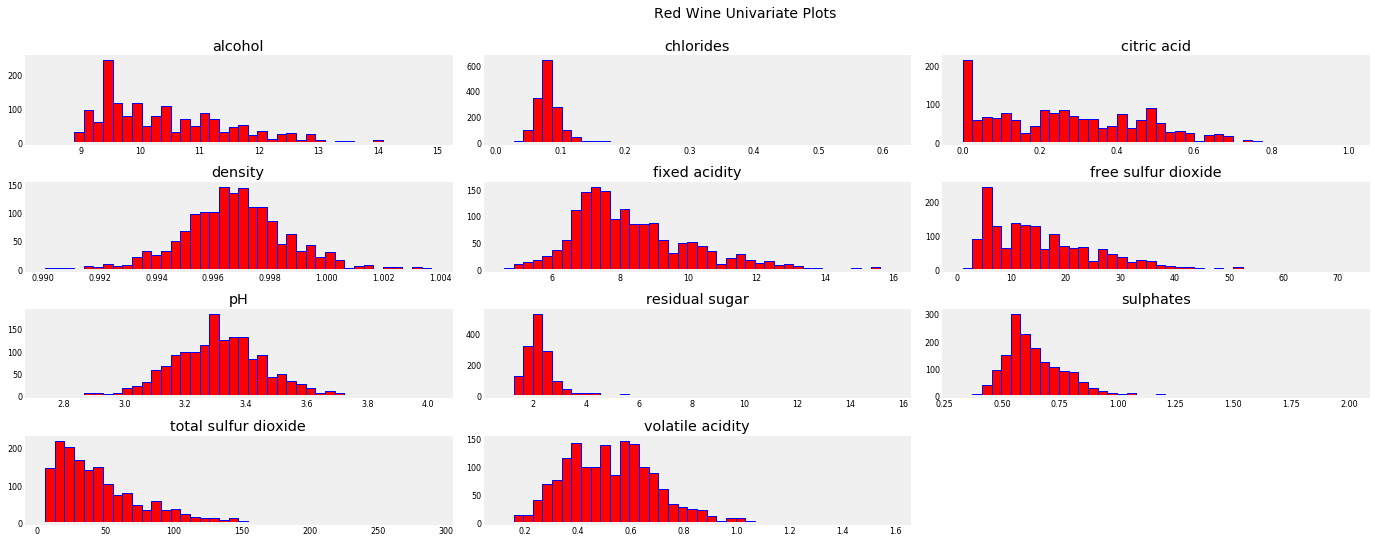

In [8]:
wines[features_list].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Red Wine Univariate Plots', x=0.65, y=1.25, fontsize=14);  

> We can notice that some features, like 'sulfur dioxide' or 'sulphates' for exemple, have a right skewed distribution and should, in a real context, probably be engineered into their log forms for better results.

### Target distribution

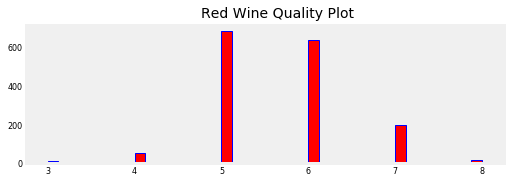

In [9]:
wines[target].hist(bins=40, edgecolor='b', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False, figsize=(6,2), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Red Wine Quality Plot', x=0.65, y=1.25, fontsize=14);  

## Multivariate Analysis

### Correlation matrix

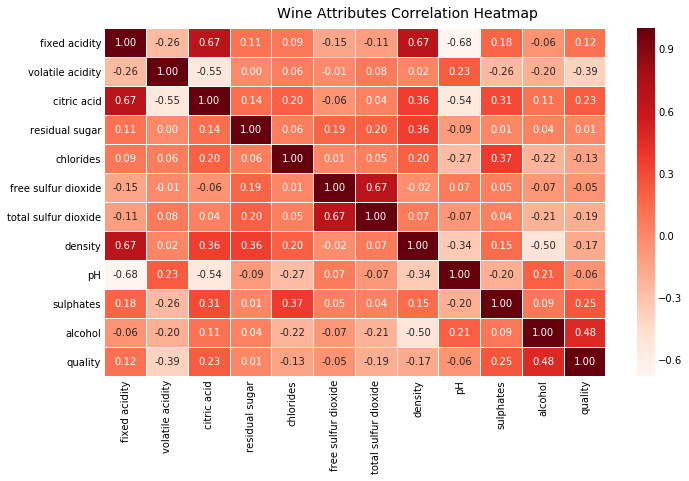

In [10]:
# for visualizing correlations
f, ax = plt.subplots(figsize=(10, 6))
corr = wines.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="Reds",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

We can see that the alcohol level has the strongest postive correlation (0.48) with the quality notation.

There is also an understandable negative correlation between 'pH' and the 'fixed acidity' of the wine: 
- the pH is the mesure of acidity/basicity with a scale between 0 (very acid) and 14 (very basic) with a midscale at 7 (neutral)
- the definition of pH is the negative log of H+ ion (hydrogen ion)
- so the more acidic is a solution, the more the concentration of H+ is hight, the more pH tends toward 0.
- as indicated in the data description, most wines are acidic and have a pH of 3-4

## Bivariate Features vs Target 

### exemple : 'alcohol' vs 'quality' plot : 

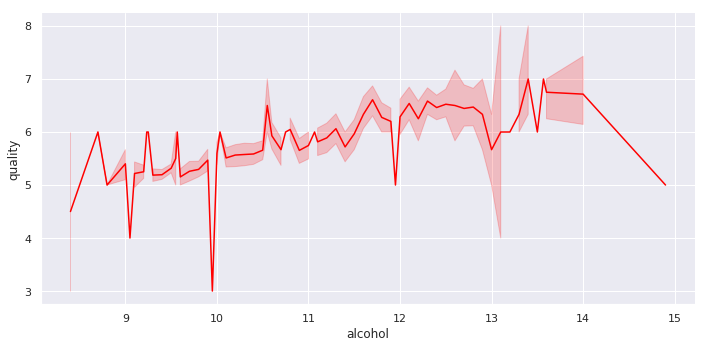

In [11]:
sns.set()
sns.relplot(data=wines, x='alcohol', y=target, kind='line', height=5, aspect=2, color='red');    

> We can visualy confirm here the global positve correlation seen precedently between the 'alcohol' level (< 14) and the final quality score. Of course, feel free to try other features.

# Building Train and Test Datasets

Now for sake of simplicity let's transform our target data to a binary classification problem ('Low' vs 'Hight' quality wine) and build our train and test datasets on a classical 70/30 ratio.

In [12]:
# create our separate target vector 
y = wines.pop('quality')

# mapping the target to a binary class at quality = 5
y = y.apply(lambda x: 0 if x <= 5 else 1)

# quickly check that we have a balanced target partition
y.sum() / len(y)

0.5347091932457786

In [13]:
# building train/test datasets on a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(wines, y, test_size=0.3, random_state=33)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

<a name="model"></a>
# Training our classification model

We will now instanciate and train an out-of-the-box **XGBoost classification model** on our train data

In [14]:
%%time

# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

CPU times: user 260 ms, sys: 12 ms, total: 272 ms
Wall time: 80 ms


# Model Performance Evaluation

Now let's test our model and evaluate how it has performed with its predictions on the test data. We won't perform here any cross-validation on our model, as one should probably do in a real context.

# Making predictions on the test data and performance evaluation

## Prediction

In [15]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

## Evaluation of performance

### Accuracy, Precision/Recall, F1 Metrics & Confusion matrix

In [16]:
# We design a simple classification evaluative function
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame) 

In [17]:
# Evaluate predictions
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 0.7521
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  Low Quality       0.73      0.74      0.73       221
Hight Quality       0.78      0.76      0.77       259

    micro avg       0.75      0.75      0.75       480
    macro avg       0.75      0.75      0.75       480
 weighted avg       0.75      0.75      0.75       480

------------------------------------------------------------
Confusion matrix:

          Predicted:     
                   0    1
Actual: 0        164   57
        1         62  197


### AUC / ROC Curve

AUC / ROC Curve is probably a better evaluations for this classification task :

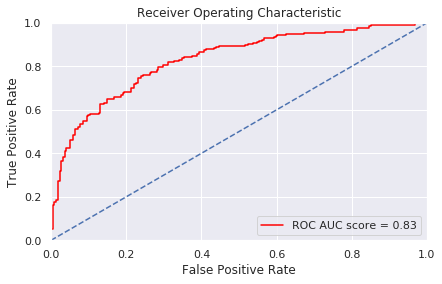

In [18]:
# calculate the FPR and TPR for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

> So : F1 = 0.75 and AUC = 0.83 : well, not too bad without any tuning or feature engineering.

<br><br>
>>> Now let's dive into the **interpretation of our model**:

# The trade-off Accuracy / Interpretability

In general machine learning design there is well known trade-offs between the bias and the variance of a model, or between precision and recall in classification algorithms for exemple.

Similarly, in ML Interpretability, there is the **Accuracy / Interpretability trade-off** rule of thumb which states that generally, the more accurate is a model (or a model of models, like ensemble's bagging and boosting), the more complex it is and so the more difficult it is to interpret it's outputs.

<img src="https://raw.githubusercontent.com/cog-data/ML_Interpretability_tutorial/master/img/accuracy_interpretability.png" title="The Accuracy vs Interpretability trade-off" />

More, accuracy cannot stand alone for buiding trust on our models because of possible overfitting of the model, correlations of the features and noise in the data.

So we need more sophisticated metrics and analytics than just plain accuracy of the results.

# Default Model Interpretation Methods

__Non-parametrics models__ like tree-based models as XGBoost are more difficult to interprete because their total number of parameters is not fixed and will grow with the volume of data used for the training. Parametrics models (ex: logistic regression) offers a contrario a first level of interpretation by the way of their coefficients (but in fact even this is not completely trivial). In that case, regularization techniques like L1-regularization/LASSO can be usefull to reduce the feature space and improving the interpretability of the model. For non-parametric models, fortunately, many of them like XGBoost give an access to interpretation methods like feature importance for helping us to understand the inner evaluation of the model for making his predictions.

<a name="features_importance"></a>
## Features importance

To interpret a model, we basically need to know :

- which features are the most important in the model
- the effect of each feature on a particular prediction
- the effects of each feature over a large number of predictions
    
Native global feature importance calculations that come with XGBoostare are based on the following parameters :

- Feature Weights: based on the number of times a feature appears in a tree across the ensemble of trees
- Coverage: the average coverage (number of samples affected) of splits which use the feature
- Gain: the average gain of splits which use the feature

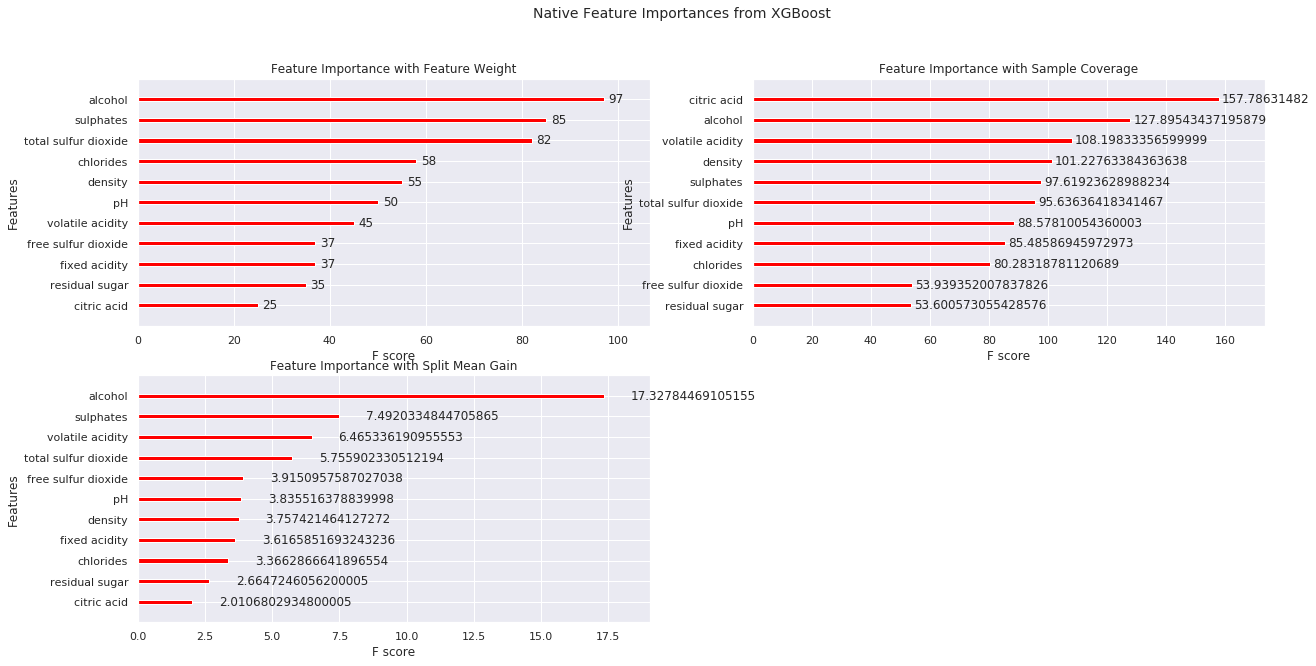

In [19]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain");

> As you can see, features are ordered in differents ways by these different criterions. We need a more **consistent** way of doing so. As we will see later, Shapley values for exemple offer us such a consistent way.

#  ELI5 Model Interpretation

According to their documentation, __[ELI5](https://github.com/TeamHG-Memex/eli5)__ ("Explain Like I'm 5") is a Python library which helps to debug machine learning classifiers and regressors and explain their predictions in an easy to understand an intuitive way. ELI5 is a good starting point and support tree-based and parametric/linear models and also text processing and HashingVectorizer utilities from scikit-learn but **doesn't support true model-agnostic interpretations**.

## Installation

In [20]:
# pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

## Feature Importances

With XGBoost, ELI5 just use the same native feature importances computation methods (with the default "gain" parameter) which we have just seen earlier and  give us an easy and ergonomic way of displaying it with the `eli5.show_weights` method.

In [21]:
eli5.show_weights(xgb.get_booster())

Weight,Feature
0.2878,alcohol
0.1244,sulphates
0.1074,volatile acidity
0.0956,total sulfur dioxide
0.0650,free sulfur dioxide
0.0637,pH
0.0624,density
0.0601,fixed acidity
0.0559,chlorides
0.0443,residual sugar


## Explaining Model Prediction Decisions with ELI5

To make random forest predictions more interpretable, every prediction of the model can be presented as a sum of feature contributions (plus the bias), showing how the features lead to a particular prediction. ELI5 does it by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across all trees. This is a good step in direction of model-agnostic interpretation but not entirely model-agnostic like, we will see it later, for LIME.

Let's examine individual data-point predictions, one for each class ("0" : quality wine scored <= 5 with a label of "Low Quality" wine, and "1" with score > 5 and a label of "Hight Quality") with the `eli5.show_prediction` method.

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [22]:
wine_nb = 0
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', xgb_predictions[wine_nb])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[wine_nb], 
                     feature_names=list(wines.columns), show_feature_values=True)

Reference: 0
Predicted: 0


> In this successfully individual prediction, the top 3 influential features seems to be, after the bias, the pH, total sulfur dioxide, and chlorides.

> NB: you can understand "BIAS" here as the expected average score output by the model, based on the distribution of the training set. If you want more explanation about his meaning in Eli5 and in this context (XGBoost model), you can check out this [Stackoverflow thread](https://stackoverflow.com/questions/49402701/eli5-explaining-prediction-xgboost-model).

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [23]:
wine_nb = 4
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', xgb_predictions[wine_nb])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[wine_nb], 
                     feature_names=list(wines.columns), show_feature_values=True)

Reference: 1
Predicted: 1


> And in this one, sulfate, total sulfur dioxide, and volatile acidity seems to be prevalent.

> Notice how a feature like 'sulphates' play an opposite influential role in explaining model prediction between the two classes and acts like a flag in these two particular examples .

### Features Permutation Importances

Eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA). This is **more reliable** but this technique is **computationally slow** with a big number of features.

> __Tip:__ As in our case, If you don’t have a separate held-out dataset, you can fit `PermutationImportance` on the same data as used for training; this still allows to inspect the model, but doesn’t show which features are important for **generalization**. So you'd better use your _validation dataset_, if you have one, for computing your features permutation importances.

In [24]:
%%time

# we need to retrain a new model with arrays
# as eli5 has a bug with Dataframes and XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train, y_train)

CPU times: user 216 ms, sys: 24 ms, total: 240 ms
Wall time: 64.2 ms


In [25]:
feat_permut = PermutationImportance(xgb_array, random_state=33).fit(X_train, y_train)
eli5.show_weights(feat_permut, feature_names = features_list)

Weight,Feature
0.1659 ± 0.0168,alcohol
0.0811 ± 0.0166,sulphates
0.0533 ± 0.0088,total sulfur dioxide
0.0343 ± 0.0087,chlorides
0.0313 ± 0.0082,volatile acidity
0.0216 ± 0.0036,free sulfur dioxide
0.0181 ± 0.0041,density
0.0173 ± 0.0077,pH
0.0127 ± 0.0057,citric acid
0.0091 ± 0.0103,fixed acidity


> You can compare this result with the basic feature classification (ie without permutation). What are the differences ? What can you infer about the reliability of these features ?

<a name="pd_plots"></a>
# Partial Dependence Plots (PD plot)

"The partial dependence plot (PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 200127). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonous or more complex." (from PDPbox documentation).

Simply put, while feature importance shows **WHAT** variables most affect predictions, partial dependence plots show **HOW** a feature affects predictions. 

Here we will be using the dedicated __[PDPbox library](https://christophm.github.io/interpretable-ml-book/pdp.html)__. 

## Installation

In [26]:
# pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

## Univariate PD Plots

In [27]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

Let's see how the feature 'alcohol' behave (with confidence interval):

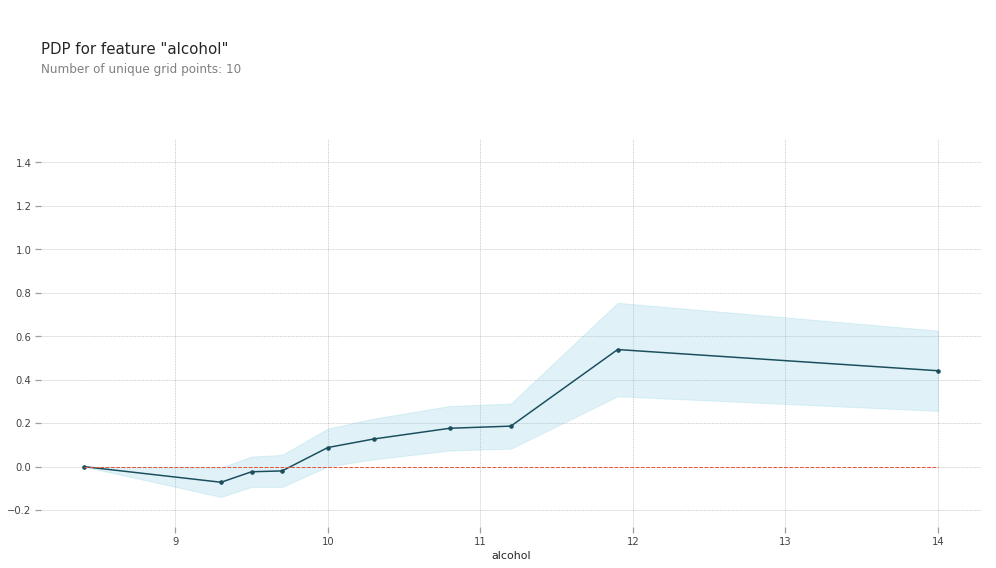

In [28]:
# plot the PD univariate plot
plot_pdp(xgb, X_train, 'alcohol')

> This PD plot show us that the alcohol level seems to have an increasing positive influence on the prediction of "Hight Quality" wines for values between 9.7 and 11.8. After that treshold the influence is still positive but decreasing progressively, and before that it was neutral/very slightly negative.

> explore by yourself important features like 'sulphates' and 'total sulfur dioxide'. What can your a priori infer from their PD Plot ?

<a name="ice_plots"></a>
## Univariate ICE plot

ICE plots are similar to PD plots but offer a more detailled view about the behavior of near similar clusters around the PD plot average curve. ICE algorithm gives the user insight into the several variants of conditional relationships estimated by the black box.

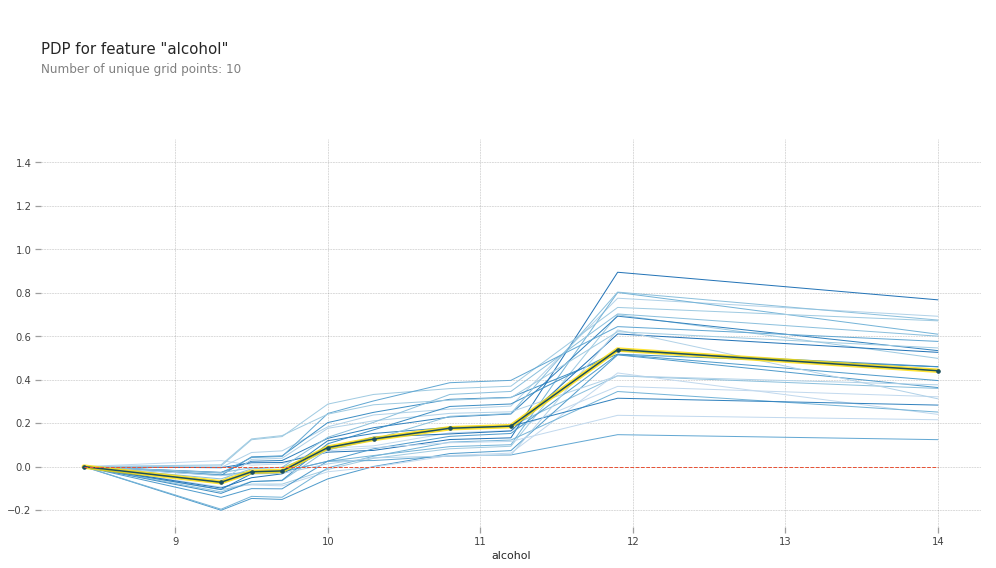

In [29]:
# for ICE plot we must specify the numbers of similarity clusters we want
# here 24
plot_pdp(xgb, X_train, 'alcohol', cluster_flag=True, nb_clusters=24, lines_flag=True)

### Bivariate PD plot

Let's now explore a bivariate PD plot between 'pH' and the 'fixed acidity' feature :

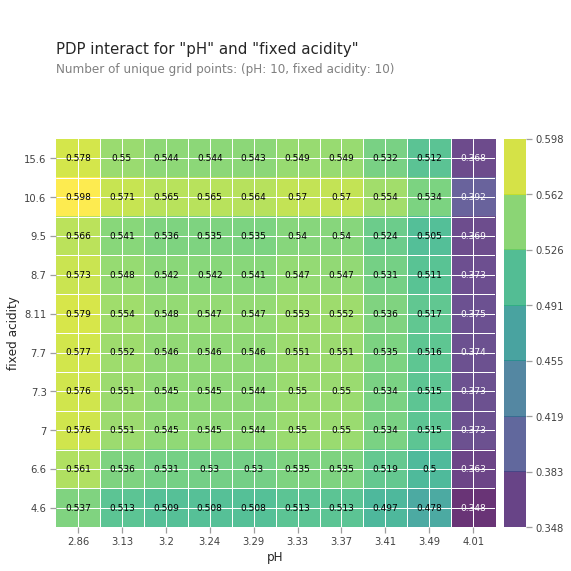

In [30]:
features_to_plot = ['pH', 'fixed acidity']
inter1  =  pdp.pdp_interact(model=xgb, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

# we use plot_type='grid' as the default and better option 'contour' has a bug which is being corrected
# cf. https://github.com/SauceCat/PDPbox/issues/40

plt.show()

> Going further: a [tutorial dedicated to PDPbox and ICE plots](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312).

***

<a name="skater"></a>
#  SKATER Model Interpretation

SKATER is a relative new MLI framework and documentation is not easily accessible for now. This part is heavily inspired by [this article](https://www.oreilly.com/ideas/interpreting-predictive-models-with-skater-unboxing-model-opacity) and by an [extensive and really great tutorial on MLI made by Dipanjan Sarkar](https://towardsdatascience.com/explainable-artificial-intelligence-part-2-model-interpretation-strategies-75d4afa6b739) which will also be referenced in the last "Going further about MLI" section at the end of this tutorial.

"Skater is a unified framework to enable Model Interpretation for all forms of models to help one build an Interpretable machine learning system often needed for real world use-cases using a model-agnostic approach. It is an open source python library designed to demystify the learned structures of a black box model both globally (inference on the basis of a complete data set) and locally (inference about an individual prediction).

<img src="https://raw.githubusercontent.com/cog-data/ML_Interpretability_tutorial/master/img/local_glocal_interpretation.png" alt="accuracy-interpretability-trade-off" title="The Accuracy vs Interpretability trade-off" />

Skater originally started off as a fork of LIME but then broke out as an independent framework of it's own with a wide variety of feature and capabilities for model-agnostic interpretation for any black-box models. The project was started as a research idea to find ways to enable better interpretability (preferably human interpretability) to predictive "black boxes" both for researchers and practioners." 

Check out the __[the GitHub repository of SKATER](https://github.com/oracle/Skater)__ for more informations.

## Global / Local Interpretations

Predictive models maps an input space to an output space. There is two types of interpretation algorithms :
- **Global interpretation algorithms** who offers statistics and metrics on the joint distribution of the entire training set, which generally must reduce by  aggregating or subseting the feature space to be "human-interpretable".
- **Local interpretation algorithms** which only deal with regions of the domain, such as the marginal distribution of a feature. 

## Creating an interpretation object

The general workflow within the skater package is to create an interpretation, create a model, and run interpretation algorithms. Typically, an `Interpretation` consumes a dataset, and optionally some metadata like feature names and row ids. Internally, the `Interpretation` will generate a `DataManager` to handle data requests and sampling.

- Local Models: to create a skater model based on a local function or method, pass in the predict function to an `InMemoryModel`. A user can optionally pass data samples to the examples keyword argument. This is only used to infer output types and formats. Out of the box, skater allows models return numpy arrays and pandas dataframes.

- Operationalized Model: If your model is accessible through an API, use a `DeployedModel`, which wraps the requests library. `DeployedModels` require two functions, an input formatter and an output formatter, which speak to the requests library for posting and parsing. The input formatter takes a pandas DataFrame or a numpy ndarray, and returns an object (such as a dict) that can be converted to JSON to be posted. The output formatter takes a requests.response as an input and returns a numpy ndarray or pandas DataFrame.

## Installation

In [31]:
# installation of skater can be tricky, try :
# pip install -U skater
# conda install --yes -c conda-forge skater

# check out skater installation instructions at 
# https://oracle.github.io/Skater/install.html

# for testing the installation
# ! python -c "from skater.tests.all_tests import run_tests; run_tests()"

In [32]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

ModuleNotFoundError: No module named 'skater'

## Workflow : Interpretation object > in-memory Model > Interpretation

In [33]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=features_list)
im_model = InMemoryModel(xgb.predict_proba, examples=X_train, target_names=['Low Quality', 'Hight Quality'])

NameError: name 'Interpretation' is not defined

## Feature Importances with Skater

Feature importance is generic term for the degree to which a predictive model relies on a particular feature. The skater feature importance implementation is based on an information theoretic criteria, measuring the entropy in the change of predictions, given a perturbation of a given feature. The intuition is that the more a model's decision criteria depend on a feature, the more we'll see predictions change as a function of perturbing a feature. The default method used is `prediction-variance` which is the mean absolute value of changes in predictions, given perturbations in the data.

In [34]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, progressbar=False)

NameError: name 'interpreter' is not defined

## Partial Dependence plots with SKATER

PD plots can also be generated with the SKATER library : 

### PD plot of 'pH' affecting model prediction

In [35]:
r = interpreter.partial_dependence.plot_partial_dependence(['pH'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=1000, 
                                                           with_variance=True, figsize = (6, 4), n_jobs=-1)
yl = r[0][1].set_ylim(0, 1) 

NameError: name 'interpreter' is not defined

> There is a clear gap for pH = 3.5 +/- 0.1 relative to the effect of this feature on the prediction of the probability of the wine being of 'Hight Quality'

### Bivariate PD Plot showing interactions between features 'pH' and 'fixed acidity' and their effect on the 'quality' classification

In [36]:
%%time
# beware : this process is computationally slow/heavy

plots_list = interpreter.partial_dependence.plot_partial_dependence([('pH', 'fixed acidity')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=1000,
                                                                    figsize=(16, 6),
                                                                    grid_resolution=100,
                                                                    progressbar=True,
                                                                    n_jobs=-1)

NameError: name 'interpreter' is not defined

> Here, if we look carefully, we can see again the same effect but this time with an additional inhibitory/negative effect (the "canyon" in the middle of the feature sub-space) of the fixed acidy for values around 0.012 (NB: the effect is much more visible with an unique definition class, ie `target_names`, in the preceding InMemoryModel call)

# Local Interpretations with Skater

Local Interpretation could possibly be achieved in two ways: 
- Firstly, one could possibly approximate the behavior of a complex predictive model in the vicinity of a single input using a simple interpretable auxiliary or surrogate model (e.g. Linear Regressor)
- Secondly, one could use the base estimator to understand the behavior of a single prediction using intuitive approximate functions based on inputs and outputs.

## Local Interpretable Model-Agnostic Explanations (LIME)

LIME is an algorithm designed by Riberio Marco, Singh Sameer, Guestrin Carlos to access the behavior of the any base estimator (model) using interpretable surrogate models (e.g. linear classifier/regressor). 

Such form of comprehensive evaluation helps in generating explanations which are **locally faithful but may not align with the global behavior**. 

Basically, LIME explanations are based on local surrogate models. Surrogate models are interpretable models (like a linear model or decision tree) that are learned on the predictions of the original black box model. But instead of trying to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Following is a standard high-level workflow for this:

 - Choose your instance of interest for which you want to have an explanation of the predictions of your black box model.
 - Perturb your dataset and get the black box predictions for these new points.
 - Weight the new samples by their proximity to the instance of interest.
 - Fit a weighted, interpretable (surrogate) model on the dataset with the variations.
 - Explain prediction by interpreting the local model.
 
We recommend you to read the [LIME chapter](https://christophm.github.io/interpretable-ml-book/lime.html) in Christoph Molnar's excellent book on Model Interpretation which talks about this in detail.

<a name="lime"></a>
## Explaining Model Predictions with Skater using LIME

Skater can leverage LIME to explain model predictions. Typically, its `LimeTabularExplainer` class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. The `explain_instance()` function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.

Since XGBoost has some issues with feature name ordering when building models with dataframes, so we will use our yet fitted xgb_array model to make LIME work without additional hassles of feature re-ordering. 

In [37]:
predictions = xgb_array.predict_proba(X_test.values)

ValueError: feature_names mismatch: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
expected free sulfur dioxide, citric acid, fixed acidity, residual sugar, sulphates, chlorides, pH, volatile acidity, alcohol, total sulfur dioxide, density in input data
training data did not have the following fields: f3, f5, f8, f0, f4, f7, f6, f10, f1, f9, f2

In [38]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=features_list, discretize_continuous=True, class_names=['Low Quality', 'High Quality'])

ModuleNotFoundError: No module named 'skater'

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [39]:
wine_nb = 0
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', predictions[wine_nb])
exp.explain_instance(X_test.iloc[wine_nb].values, xgb_array.predict_proba).show_in_notebook()

Reference: 0


NameError: name 'predictions' is not defined

> We can see that this model has taken this particular decision (82% chance that this wine will be scored as 'Low Quality') by puting forward the 'alcohol', 'sulphates' and 'volatile acidity' features, and we could know to which degree by looking at the associated values.

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [40]:
wine_nb = 4
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', predictions[wine_nb])
exp.explain_instance(X_test.iloc[wine_nb].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1


NameError: name 'predictions' is not defined

> We can again see that SKATER LIME gives a nice display showing which features were the most influential in the model taking the correct decision of predicting the wine quality score, here for a 'Hight Quality' wine.

<a name="skater_tree"></a>
## Tree Surrogates with SKATER

We have see various ways to interpret machine learning models with features, dependence plots and even LIME. But can we build an approximation or a surrogate model which is more interpretable from a really complex black box model like our XGBoost model having hundreds of decision trees?

Here in, we introduce the idea of using __`TreeSurrogates`__ as means for explaining a model's learned decision policies (for inductive learning tasks), which is inspired by the work of Mark W. Craven described as the TREPAN algorithm. 

We recommend checking out the following excellent papers on the TREPAN algorithm to build surrogate trees.
 - [_Mark W. Craven(1996) EXTRACTING COMPREHENSIBLE MODELS FROM TRAINED NEURAL NETWORKS_](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/craven.thesis.pdf)
 - [_Mark W. Craven and Jude W. Shavlik(NIPS, 96). Extracting Thee-Structured Representations of Thained Networks_](https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf)

Briefly, Trepan constructs a decision tree in a best-first manner. It maintains a queue of leaves which are expanded into subtrees as they are removed from the queue. With each node in the queue, Trepan stores,

 - a subset of the training examples, 
 - another set of instances (query instances),
 - a set of constraints. 

The stored subset of training examples consists simply of those examples that reach the node. The query instances are used, along with the training examples, to select the splitting test if the node is an internal node or to determine the class
label if it is a leaf. The constraint set describes the conditions that instances must satisfy in order to reach the node; this information is used when drawing a set of query instances for a newly created node. The process of expanding a node in Trepan is much like it is in conventional decision tree algorithms: a splitting test is selected for the node, and a child is created for each outcome of the test. Each child is either made a leaf of the tree or put into the queue for future expansion.


For Skater's implementation, for building explainable surrogate models, the base estimator ("Oracle") could be any form of a supervised learning predictive model - our black box model. The explanations are approximated using Decision Trees (both for Classification/Regression) by learning decision boundaries similar to that learned by the Oracle (predictions from the base model are used for learning the Decision Tree representation). The implementation also generates a fidelity score to quantify tree based surrogate model’s approximation to the Oracle. Ideally, the score should be 0 for truthful explanation both globally and locally. Let's check this out in action!

__NOTE:__ The implementation is currently experimental and might change in future.

### Using the interpreter instance invoke call to the TreeSurrogate

In [41]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=33)

NameError: name 'interpreter' is not defined

### Using the surrogate model to learn the decision boundaries learned by the base estimator
 - Reports the fidelity value when compared to the base estimator (closer to 0 is better)
 - Learner uses F1 score as the default metric of choice for classification.

In [42]:
f1 = surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')
print('F1 score for the surrogate tree: ', f1)

NameError: name 'surrogate_explainer' is not defined

### Visualizing the Surrogate Tree

Let's visualize our surrogate tree with the 'Low Quality' (score <= 5) class in pink and 'High Quality' class (score > 5) in red, but before let's display a reminder of the features names :

In [43]:
# A reminder for referencing the originals feature names 
# since these names are not kept in the surrogate tree
pd.DataFrame([('X'+str(idx), feature) for (idx, feature) in enumerate(wines.columns)]).T

,0,1,2,3,4,5,6,7,8,9,10
0,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
1,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol


In [44]:
from skater.util.dataops import show_in_notebook

# 'Low Quality' (score <= 5) class in pink and 'High Quality' class (score > 5) in red
surrogate_explainer.plot_global_decisions(colors=['pink', 'red'], file_name='test_tree_sur.png', fig_size=(8,8))

show_in_notebook('test_tree_sur.png', width=1200, height=800);

ModuleNotFoundError: No module named 'skater'

### Interesting rules from the surrogate tree

Here are exemples of some interesting rules you can observe from the above tree:
- If `alcohol` > 10.017 and `sulphates` > 0.575 and `total sulfur dioxide` <= 90.5 __→__ 93.2% chance that the wine will be classified as 'Hight Quality' one.
- If `alcohol` > 11.45 and `sulphates` <= 0.575 __→__ 92.7% chance that the wine will also be classified as 'Hight Quality' one.

Of course, feel free to derive more interesting rules from this and also from your own models !

Let's look at how our surrogate model performs on the test dataset now...

### Surrogate Model Performance Evaluation

In [45]:
# using our evaluation_scores function 
surrogate_predictions = surrogate_explainer.predict(X_test)
evaluation_scores(y_test, surrogate_predictions, target_names=['low quality', 'hight quality'])

NameError: name 'surrogate_explainer' is not defined

In [46]:
# calculate the ROC AUC score for the tree surrogated model
roc_auc = metrics.roc_auc_score(y_test, surrogate_predictions)
print('ROC AUC score: ', round(roc_auc, 2))

NameError: name 'surrogate_predictions' is not defined

> As expected, the model performance drops but still we get an overall F1 score of 71% as compared to our preceding boosted model's score of 75%. On another end the AUC shows a more significant drop from 0.83 with the initial XGB model to now a weak 0.71 which cast a legitimate doubt on the validity of the preceding rules we extracted from the tree.

<a name="shap"></a>
# Model Interpretation with SHAP

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on what they claim! (do check out the [SHAP NIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).

SHAP values can explain the output of any machine learning model but for complex ensemble models it can be slow. SHAP has c++ implementations supporting  *XGBoost*, *LightGBM*, *CatBoost*, and *scikit-learn* tree models.

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach. 

An intuitive way to understand the Shapley value is the following: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value __$ϕ_{ij}$__ is the average marginal contribution of feature value __$x_{ij}$__ by joining whatever features already entered the room before, i.e.

$$\phi_{ij}=\sum_{\text{All.orderings}}val(\{\text{features.before.j}\}\cup{}x_{ij})-val(\{\text{features.before.j}\})$$

The following figure from the KDD 18 paper, [_Consistent Individualized Feature Attribution for Tree Ensembles_](https://arxiv.org/pdf/1802.03888.pdf) summarizes this in a nice way!

![](https://i.imgur.com/6Rc1dsa.png)

Let's now dive into SHAP and leverage it for interpreting our model:

## Installation

In [47]:
# ! pip install shap

import shap

# load JS visualization code to notebook
shap.initjs()

## Explain predictions with SHAP

Shapley value is the average contribution of features which are predicting in different situation.

SHAP provides multiple explainers for different kind of models.

- TreeExplainer: Support XGBoost, LightGBM, CatBoost and scikit-learn models by Tree SHAP.
- DeepExplainer (DEEP SHAP): Support TensorFlow and Keras models by using DeepLIFT and Shapley values.
- GradientExplainer: Support TensorFlow and Keras models.
- KernelExplainer (Kernel SHAP): Applying to any models by using LIME and Shapley values.

For more information about the Shapley values explanations check out [Christoph Molnar's book chapter on Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html) 

So let's play with the Tree SHAP implementation integrated into XGBoost to explain the test dataset. 

In [48]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [49]:
X_shap = pd.DataFrame(shap_values)
X_shap.tail()

,0,1,2,3,4,5,6,7,8,9,10
475,-0.006402,0.001479,-0.104184,-0.126300,0.105565,0.074569,-2.307233,-0.141250,-0.089822,0.242516,-0.028095
476,-0.093757,-0.563107,0.017742,-0.043157,-0.181692,-0.108295,0.126078,0.155686,-0.205023,0.153876,0.419077
477,-0.005326,0.029216,-0.087567,0.105751,0.356834,0.067880,-0.145905,0.027254,0.051205,0.510623,2.866490
478,-0.017323,0.288997,-0.108219,-0.012148,0.090880,-0.087777,0.126913,0.031247,-0.173296,0.007923,0.194344
479,0.106930,0.012918,-0.096565,-0.016338,-0.399312,-0.085902,0.188166,-0.010606,0.352418,-0.793789,-0.947258


We get a matrix of SHAP values with the same shape as the original X_test set. Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as `expected_value` attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

In [50]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  0.14833762


## Feature Importances with SHAP

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

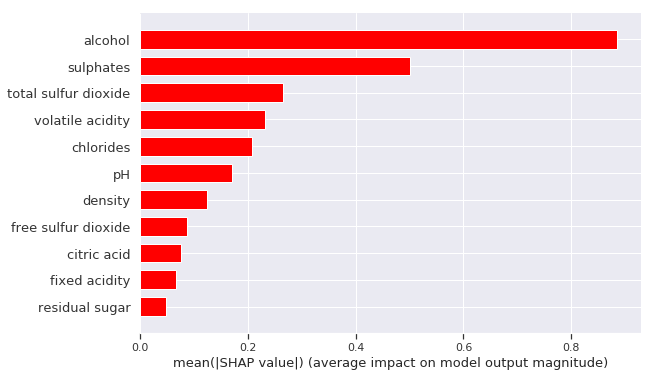

In [51]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [52]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

> Reminder : features pushing the prediction higher than the base value are shown in red, those pushing the prediction lower are in blue.

> SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting that this wine will be scored as 'Low Quality'. The above explanation shows features each contributing to push the model output from the 'base value' (the average model output over the training dataset we passed) to the actual model output.

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [53]:
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:])

## Visualizing and explaining multiple predictions

SHAP can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.

In [54]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

> __Tip__: Notice the drop-down menus at the top of the graph with multiple display and ordering options and also on the left for isolating and highlighting multiple or individual features effects.

> The above visualization can be interacted with in multiple ways. The visualization shows for exemple some interesting model prediction pattern decisions. For exemple :
>
>- The first 90 test samples all probably are classified as 'Hight Quality' wines and that have a hight alcohol degree (> 11.3) that you can highlight by choosing in the left menu 'alcohol effects'
>- If you display the 'alcohol' feature with the top drop-down menu, you can confirm that the alcohol level begin to play an important role in pushing upward the prediction at a level around 11.3.
>- for 'pH', we can confirm a behavioral shift of the model after 3.5, as seen before. 

> What about 'sulphates' and 'total sulfur dioxide' that we saw before ? Does it confirm the first hypotheses you made with the PD plot ?

I think you would agree that it's definitely interesting to see how we can find out patterns in SHAP displays which lead us to have a better understanding why the model is making specific decisions and help us being able to provide explanations for them.

## SHAP Summary Plot

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature.

SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

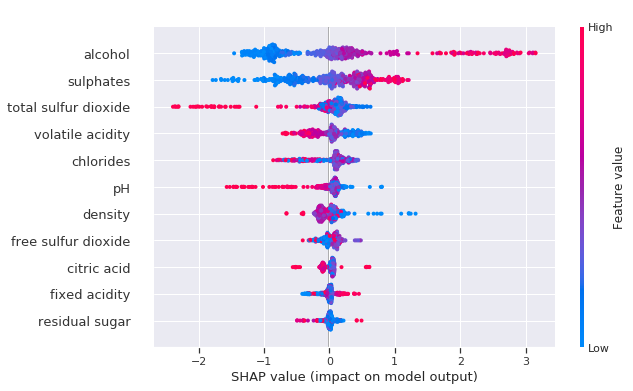

In [55]:
shap.summary_plot(shap_values, X_test)

> Notice that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

> It is interesting to confirm again that hight values of 'alcohol' play positive important role in the final prediction, and hight values of 'total sulfur dioxide' seems a contrario to have a negative impact on predicting "hight quality" wines.

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

### PD plot of 'pH' (and influence of 'fixed acidity') affecting model prediction

We can use the `dependence_plot` method for ploting the effect of a feature on the prediction with or without the influence of another feature. If you don't give any `interaction_index` parameter, SHAP will decide by itself and propose automatically an interaction feature for you.

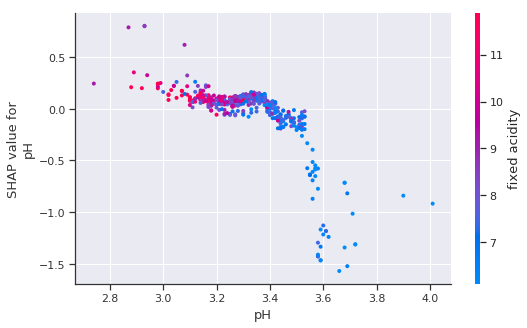

In [56]:
shap.dependence_plot(ind='pH', interaction_index='fixed acidity',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

> Again, you can play also with 'total sulfur dioxide' and 'sulphates' for exemple

<a name="fairml"></a>
# Hands-on FairML (Bonus)

__[FairML](https://github.com/adebayoj/fairml)__ is a new Python library that audits black-box predictive models. The basic idea behind FairML (and many other attempts to audit or interpret model behavior) is to measure a model’s dependence on its inputs by changing them. If a small change to an input feature dramatically changes the output, the model is sensitive to the feature.

But what if the input attributes are correlated?

The trick used here to counter this multicollinearity is **orthogonal projection**. FairML orthogonally projects the input to measure the dependence of the predictive model on each attribute. Orthogonal projection of vectors is important because it allows us to completely remove the linear dependence between attributes. If two vectors are orthogonal to one another, then no linear transformation of one vector can produce the other. This intuition underlies the feature dependence measure.

One advantage of FairML is that it can audit any classifier or regressor. FairML only requires that it has a `predict function`.

See [FairML: Auditing Black-Box Predictive Models](https://blog.fastforwardlabs.com/2017/03/09/fairml-auditing-black-box-predictive-models.html) by the author for an exemple of use-case.

In [57]:

# ! pip install https://github.com/adebayoj/fairml/archive/master.zip

from fairml import audit_model
from fairml import plot_dependencies

ModuleNotFoundError: No module named 'fairml'

In [58]:
%%time

xgb_fair = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)

xgb_fair.fit(X_train.values, y_train)

CPU times: user 212 ms, sys: 24 ms, total: 236 ms
Wall time: 63.8 ms


Now, we import the two key methods from fairml.
audit_model takes:

- (required) black-box function, which is the model to be audited
- (required) sample_data to be perturbed for querying the function. This has to be a pandas dataframe with no missing data.

- other optional parameters that control the mechanics of the auditing process, for example:
  - number_of_runs : number of iterations to perform
  - interactions : flag to enable checking model dependence on interactions.

audit_model returns an overloaded dictionary where keys are the column names of input pandas dataframe and values are lists containing model  dependence on that particular feature. These lists of size number_of_runs.


In [59]:
%%time

# call audit model
feat_importances, _ = audit_model(xgb_fair.predict, X_train, distance_metric='accuracy', direct_input_pertubation_strategy='constant-zero',
                                 number_of_runs=50, include_interactions=True)

# print feature importance
print(feat_importances)

NameError: name 'audit_model' is not defined

In [60]:
# generate feature dependence plot
fig = plot_dependencies(
    feat_importances.median(),
    reverse_values=False,
    title="FairML feature dependence XGB model",
    fig_size=(8,3)
    )

# Print it in a file
file_name = "fairml_wine_quality.png"
plt.savefig(file_name, transparent=False, bbox_inches='tight', dpi=250)

NameError: name 'plot_dependencies' is not defined

> Cap'tain Obvious tip: red color indicates that the factor highly contributes to the model prediction (yeah, i know, "what about the blue?")

> You can play with the different parameters like the `include_interactions` flag or with `direct_input_pertubation_strategy` referring to how to zero out a single variable with three different options:
- 'constant-zero': replace with a random constant value
- 'constant-median': replace with median constant value
- 'random-sample': replace all values with a random permutation of the column

> Well, is FairML itself really "fair" ? What do you think ?

<a name="further_readings"></a>
# Last but not least : going further about MLI...

Here's some curated ressources about Machine Learning Interpretability:

- A __[practical and knowledgeable tutorial on Kaggle Learn](https://www.kaggle.com/learn/machine-learning-explainability)__ by Dan Becker, with interactives exercices (permutation importance, partial plots, Shap values)

- A detailed and really great tutorial about MLI in 4 parts by Dipanjan (DJ) Sarkar :
 -  __[The Importance of Human Interpretable Machine Learning](https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476)__
 -  __[Model Interpretation Strategies](https://towardsdatascience.com/explainable-artificial-intelligence-part-2-model-interpretation-strategies-75d4afa6b739)__
 -  __[Hands-on Machine Learning Model Interpretation](https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608)__
 -  __Part 4 not published yet...__
 

- Another nice tutorial : __[Interpretable Machine Learning with Python](http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html)__ by Savvas Tjortjoglou

- A great online book about MLI : __[Interpretable Machine Learning : A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)__ by Christoph Molnar

- An article by qualified experts of the field (Patrick Hall & Al. from H2O.ai): __[Ideas on interpreting machine learning](https://www.oreilly.com/ideas/ideas-on-interpreting-machine-learning)__
    
- For the more greedy, the __[awesome-machine-learning-interpretability repository](https://github.com/jphall663/awesome-machine-learning-interpretability)__, dedicated to the subject with plenty of ressources.


<br>
<center>-----------------------------------------</center>
<br>

__Congratulations to those who have made it so far (and also to the others) !__

_I hope that this tutorial has interested you and that it will be usefull and inspiring as an introduction to this important, complex and very interesting topic. It should be obvious now that human must stay in the loop, as machines don't have in fact any real semantic skills unless they are assigned by a human consensus, and may be AI should better stand for "Additive Intelligence". Anyway, the current preoccupation for this subject alone shows that ML has reached a sufficient maturity so that we, human beings, could now learn very interesting insights from the internal behavior of the very same ML/AI models we produce. And that's a nice and interesting cybernetics and cognitive feedback loop... so, who will explain the explainer?_

_"A votre santé" ! / Cheers !_ 

`Christophe Rigon > datacog@free.fr`